In [ ]:
import firebase_admin
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from firebase_admin import credentials, firestore
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['21000', '31000', '41000', '51000', '61000', '12345', '71000', '91000']
ACTIVITIES = ['sit', 'walk', 'stairs']
SAMPLING_RATE = 100
OVERLAP = 0.5
CHUNK_SIZE = 1
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior for CuDNN (GPU)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def fetch_data_by_treatment(treatment_filter):
    data_raw, docs = [], []
    data_ref = db.collection("data").document(treatment_filter)

    for patient_id in INCLUDE_ONLY:
        subject_ref = data_ref.collection(patient_id)
        for activity in ACTIVITIES:
            activity_ref = subject_ref.document(activity)
            phone_location_col = activity_ref.collections()
            for phone_location in phone_location_col:
                for recording in phone_location.stream():
                    record = recording.to_dict()
                    if 'acceleration' not in record:
                        continue
                    df = pd.DataFrame(record['acceleration'])
                    timestamps = df['timestamp']
                    min_time = timestamps.min()
                    max_time = timestamps.max()
                    df = df[(timestamps >= min_time + 2500) & (timestamps <= max_time - 2500)]
                    if df.empty:
                        continue
                    combined = pd.DataFrame({
                        'ax': df['accelerometer'].apply(lambda x: x['x']),
                        'ay': df['accelerometer'].apply(lambda x: x['y']),
                        'az': df['accelerometer'].apply(lambda x: x['z']),
                        'gx': df['gyroscope'].apply(lambda x: x['x']),
                        'gy': df['gyroscope'].apply(lambda x: x['y']),
                        'gz': df['gyroscope'].apply(lambda x: x['z']),
                    })
                    data_raw.append(combined)
                    docs.append({'activity': activity, 'patient': patient_id})

    return data_raw, docs

def chunk_data_raw(data_raw, docs, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    data, labels, subjects = [], [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))
    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                labels.append(ACTIVITIES.index(docs[i]['activity']))
                subjects.append(docs[i]['patient'])
    return np.array(data), np.array(labels), np.array(subjects)

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=6, emb_size=32, nhead=4, nhid=64, nlayers=2, nclasses=len(ACTIVITIES), dropout=0.3):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, emb_size),
            nn.LayerNorm(emb_size)
        )
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.dropout_fc = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(emb_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, nclasses)
        )
        self.emb_size = emb_size

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.dropout_fc(x)
        x = self.classifier(x)
        return x

In [6]:
def train_and_evaluate_pre_post(noise_std=0.01):
    # Fetch training data
    before_raw, before_docs = fetch_data_by_treatment('BeforeTreatment')
    X_before, y_before, subjects_before = chunk_data_raw(before_raw, before_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    # Split train/val
    X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
        X_before, y_before, test_size=0.2, random_state=42, stratify=y_before
    )

    # Fetch testing data
    after_raw, after_docs = fetch_data_by_treatment('AfterTreatment')
    X_after, y_after, subjects_after = chunk_data_raw(after_raw, after_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    # Normalize
    scaler = StandardScaler()
    X_train_np = scaler.fit_transform(X_train_np.reshape(-1, 6)).reshape(X_train_np.shape)
    X_val_np   = scaler.transform(X_val_np.reshape(-1, 6)).reshape(X_val_np.shape)
    X_before   = scaler.transform(X_before.reshape(-1, 6)).reshape(X_before.shape)  # needed later
    X_after    = scaler.transform(X_after.reshape(-1, 6)).reshape(X_after.shape)

    def make_loader(X, y, batch_size=BATCH_SIZE, shuffle=False):
        return DataLoader(
            TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)),
            batch_size=batch_size, shuffle=shuffle
        )

    train_loader = make_loader(X_train_np, y_train_np, shuffle=True)
    val_loader   = make_loader(X_val_np, y_val_np)
    test_loader  = make_loader(X_after, y_after)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerClassifier().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    warmup_epochs = 10
    total_epochs = EPOCHS
    train_acc_history, val_acc_history, test_acc_history = [], [], []

    # Training loop
    for epoch in range(total_epochs):
        # LR scheduler with warmup and cosine decay
        if epoch < warmup_epochs:
            lr_scale = 0.1 + 0.9 * (epoch / warmup_epochs)
        else:
            lr_scale = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        for pg in optimizer.param_groups:
            pg['lr'] = LEARNING_RATE * lr_scale

        # Train step
        model.train()
        total_correct, total = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
        train_acc = total_correct / total * 100
        train_acc_history.append(train_acc)

        # Val step
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_total += yb.size(0)
        val_acc = val_correct / val_total * 100
        val_acc_history.append(val_acc)

        # Test step
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                test_correct += (preds.argmax(dim=1) == yb).sum().item()
                test_total += yb.size(0)
        test_acc = test_correct / test_total * 100
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{total_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    # Plot training history
    plt.figure(figsize=(7,5))
    plt.plot(range(1, total_epochs+1), train_acc_history, label='Train Accuracy', marker='o')
    plt.plot(range(1, total_epochs+1), val_acc_history, label='Validation Accuracy', marker='o')
    plt.plot(range(1, total_epochs+1), test_acc_history, label='Test Accuracy', marker='o')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
    plt.title('Train / Validation / Test Accuracy per Epoch')
    plt.ylim(0, 105); plt.grid(True, linestyle='--', alpha=0.5); plt.legend()
    plt.show()

    #Per-patient evaluation: Pre vs Post
    model.eval()
    TES = {}
    patient_results = {}

    all_after_labels, all_after_preds = [], []

    for patient_id in np.unique(subjects_before):
        # Patient before samples
        idx_before = subjects_before == patient_id
        Xb, yb = torch.tensor(X_before[idx_before], dtype=torch.float32).to(device), torch.tensor(y_before[idx_before]).to(device)

        # Patient after samples
        idx_after = subjects_after == patient_id
        Xa, ya = torch.tensor(X_after[idx_after], dtype=torch.float32).to(device), torch.tensor(y_after[idx_after]).to(device)

        with torch.no_grad():
            preds_before = model(Xb).argmax(dim=1).cpu().numpy()
            preds_after  = model(Xa).argmax(dim=1).cpu().numpy()

        acc_before = accuracy_score(yb.cpu().numpy(), preds_before) * 100
        acc_after  = accuracy_score(ya.cpu().numpy(), preds_after) * 100
        TES[patient_id] = acc_before - acc_after  # treatment effect = delta performance

        # Store metrics
        patient_results[patient_id] = {
            "before_acc": acc_before,
            "after_acc": acc_after,
            "TES": TES[patient_id],
            "report_after": classification_report(
                ya.cpu().numpy(), preds_after,
                labels=range(len(ACTIVITIES)),
                target_names=ACTIVITIES,
                zero_division=0,
                output_dict=True
            )
        }

        print(f"\nPatient {patient_id} results:")
        print(f"Before Accuracy = {acc_before:.2f}%")
        print(f"After Accuracy  = {acc_after:.2f}%")
        print(f"Treatment Effect Score (TES) = {TES[patient_id]:.2f}")
        print("\nAfter-Treatment Classification Report:")
        print(classification_report(
            ya.cpu().numpy(), preds_after,
            labels=range(len(ACTIVITIES)),
            target_names=ACTIVITIES,
            zero_division=0
        ))
        all_after_labels.extend(ya.cpu().numpy())
        all_after_preds.extend(preds_after)

    # Confusion Matrix
    cm = confusion_matrix(all_after_labels, all_after_preds, labels=range(len(ACTIVITIES)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('Confusion Matrix: Post Treatment')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

    # NRS improvement
    patient_improvement = {
        '21000': True,
        '31000': False,
        '41000': True,
        '51000': False,
        '61000': True,
        '12345': True,
        '71000': True,
        '91000': False
    }

    # Only use improved patients for the TES threshold
    improved_TES_values = [score for patient, score in TES.items() if patient_improvement.get(patient, False)]
    if len(improved_TES_values) > 0:
        TES_THRESHOLD = np.mean(improved_TES_values)
    else:
        TES_THRESHOLD = None

    # TES plot
    plt.figure(figsize=(8,5))
    patients = list(TES.keys())
    scores = list(TES.values())

    if TES_THRESHOLD is not None:
        colors = ['orange' if score >= TES_THRESHOLD else 'steelblue' for score in scores]
    else:
        colors = ['steelblue'] * len(scores)

    sns.barplot(x=patients, y=scores, palette=colors)
    plt.xlabel("Patient ID"); plt.ylabel("Treatment Effect Score (TES)")
    if TES_THRESHOLD is not None:
        plt.title(f"Per-Patient TES (Threshold = {TES_THRESHOLD:.1f})")
        plt.axhline(TES_THRESHOLD, color='red', linestyle='--', label=f'TES Threshold ({TES_THRESHOLD:.1f})')
        plt.legend()
    else:
        plt.title("Per-Patient TES (No responders, no threshold)")

    plt.grid(True, linestyle='--', alpha=0.5)
    for i, score in enumerate(scores):
        plt.text(i, score + 1, f"{score:.1f}", ha='center')
    plt.show()

    return {
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'test_acc_history': test_acc_history,
        'TES': TES,
        'TES_THRESHOLD': TES_THRESHOLD,
        'patient_results': patient_results
    }

Epoch 1/100 | LR: 0.000100 | Train Acc: 50.08% | Val Acc: 62.49% | Test Acc: 59.86%
Epoch 2/100 | LR: 0.000190 | Train Acc: 60.87% | Val Acc: 69.50% | Test Acc: 65.83%
Epoch 3/100 | LR: 0.000280 | Train Acc: 68.17% | Val Acc: 77.26% | Test Acc: 71.82%
Epoch 4/100 | LR: 0.000370 | Train Acc: 72.02% | Val Acc: 81.19% | Test Acc: 74.51%
Epoch 5/100 | LR: 0.000460 | Train Acc: 76.49% | Val Acc: 80.98% | Test Acc: 75.56%
Epoch 6/100 | LR: 0.000550 | Train Acc: 80.07% | Val Acc: 80.55% | Test Acc: 75.49%
Epoch 7/100 | LR: 0.000640 | Train Acc: 81.75% | Val Acc: 85.23% | Test Acc: 79.62%
Epoch 8/100 | LR: 0.000730 | Train Acc: 84.25% | Val Acc: 87.46% | Test Acc: 81.85%
Epoch 9/100 | LR: 0.000820 | Train Acc: 86.45% | Val Acc: 85.97% | Test Acc: 81.23%
Epoch 10/100 | LR: 0.000910 | Train Acc: 86.26% | Val Acc: 88.84% | Test Acc: 81.96%
Epoch 11/100 | LR: 0.001000 | Train Acc: 88.15% | Val Acc: 88.42% | Test Acc: 81.87%
Epoch 12/100 | LR: 0.001000 | Train Acc: 89.27% | Val Acc: 85.97% | Test A

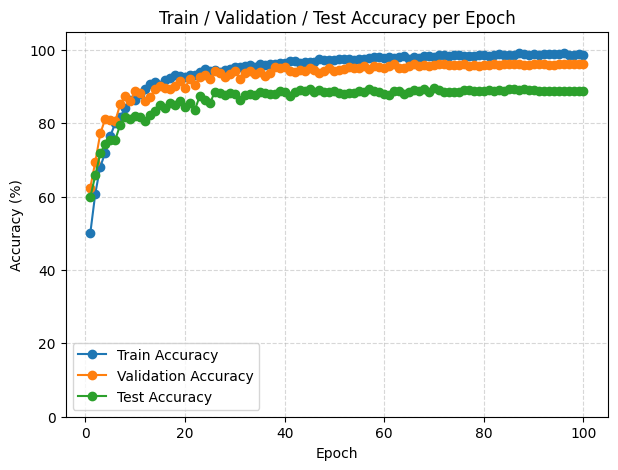


Patient 12345 results:
Before Accuracy = 98.61%
After Accuracy  = 87.33%
Treatment Effect Score (TES) = 11.28

After-Treatment Classification Report:
              precision    recall  f1-score   support

         sit       1.00      1.00      1.00       192
        walk       0.81      0.82      0.81       192
      stairs       0.81      0.80      0.81       192

    accuracy                           0.87       576
   macro avg       0.87      0.87      0.87       576
weighted avg       0.87      0.87      0.87       576


Patient 21000 results:
Before Accuracy = 98.61%
After Accuracy  = 82.81%
Treatment Effect Score (TES) = 15.80

After-Treatment Classification Report:
              precision    recall  f1-score   support

         sit       1.00      1.00      1.00       192
        walk       0.77      0.69      0.73       192
      stairs       0.72      0.79      0.75       192

    accuracy                           0.83       576
   macro avg       0.83      0.83      0.83  

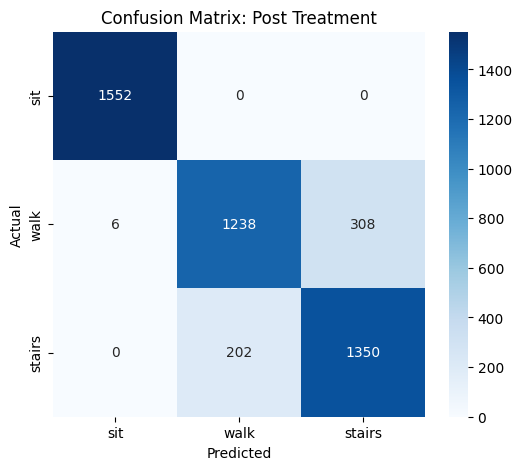

/tmp/ipython-input-2999627554.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patients, y=scores, palette=colors)


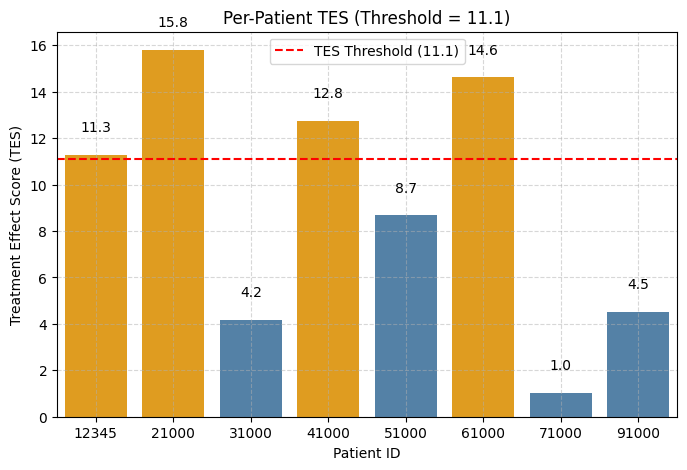

In [9]:
if __name__ == "__main__":
    train_and_evaluate_pre_post()